# Anticipez les besoins en consommation de bâtiments

# Prédiction des émissions de CO2

## Mission

Vous travaillez pour la **ville de Seattle**. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des **bâtiments non destinés à l’habitation**.

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, **vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie** de bâtiments **non destinés à l’habitation** pour lesquels elles n’ont pas encore été mesurées.

*Votre prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)*

Vous cherchez également à **évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions**, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :

- Réaliser une courte analyse exploratoire.
- Tester différents modèles de prédiction afin de répondre au mieux à la problématique.
Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes et erreurs à éviter :

**Douglas** : *L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées..*

*Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).*

*Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.*

Import des librairies utilisées et configuration

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
import timeit
import matplotlib.pyplot as plt
import seaborn as sns

Import du dataframe issu de l'analyse exploratoire

In [2]:
data = pd.read_csv('df_emission.csv')
data.head(1)

,TotalGHGEmissions,BuildingType,PrimaryPropertyType,NumberofBuildings,NumberofFloors,PropertyGFATotal,Age,ENERGYSTARScore
0,249.98,NonResidential,Hotel,0.0,12,88434,89,60.0


## Pré-processing
Je fais une copie de l'import, sans l'*ENERGYSTARScore*.

In [3]:
df = data.drop(columns='ENERGYSTARScore')
df.head(1)

,TotalGHGEmissions,BuildingType,PrimaryPropertyType,NumberofBuildings,NumberofFloors,PropertyGFATotal,Age
0,249.98,NonResidential,Hotel,0.0,12,88434,89


Les variables **X** et la target **y** sont :

In [4]:
X = df.drop(columns='TotalGHGEmissions')
y = df['TotalGHGEmissions']

Je sépare les données sur un jeu d'entraînement et un jeu de test :

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)

### Encodage - Pipeline

In [6]:
variables_numeriques = make_column_selector(dtype_include=np.number)
variables_categoriques = make_column_selector(dtype_exclude=np.number)

In [7]:
pipeline_numerique = make_pipeline(RobustScaler())
pipeline_categorique = make_pipeline(OneHotEncoder(handle_unknown='ignore'))

In [8]:
preprocesseur = make_column_transformer((pipeline_numerique, variables_numeriques),
                                      (pipeline_categorique, variables_categoriques), n_jobs=-1)

In [9]:
model = make_pipeline(preprocesseur, LinearRegression())

J'entraîne ce modèle sur les données d'entraînement :

In [10]:
model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000285A120A920>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000285A120AE60>)])),
                ('linearregression', LinearRegression())])

J'applique le modèle aux données de test :

In [11]:
y_pred = model.predict(X_test)

J'évalue l'erreur à l'aide des mesures telles que le **coefficient de détermination R²**, le **RMSE** et la **MAE**.

In [12]:
print("R² : {:.2f}".format(metrics.r2_score(y_test, y_pred)))
print('RMSE : {:.2e}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print('MAE : {:.2e}'.format(metrics.mean_absolute_error(y_test, y_pred)))

R² : 0.58
RMSE : 4.10e+02
MAE : 1.50e+02


Je vais comparer ce résultat avec une **approche naïve** utilisant un modèle renvoyant la médiane :

In [13]:
dum = DummyRegressor(strategy='median')

# Entraînement
dum.fit(X_train, y_train)

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(X_test)

# Evaluation
print("R² : {:.2f}".format(metrics.r2_score(y_test, y_pred_dum)))
print('RMSE : {:.2e}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred_dum))))
print('MAE : {:.2e}'.format(metrics.mean_absolute_error(y_test, y_pred_dum)))

R² : -0.07
RMSE : 6.54e+02
MAE : 1.96e+02


Quel que soit le type de mesure, **le modèle de régression de base fait mieux que l'approche naïve**.

## Modélisations
Je vais tester différents modèles basés sur :
- les plus proches voisins avec **KNeighbors**
- la régression linéaire avec **Ridge**
- une SVM à noyaux avec **SVR**
- régression ridge à noyau avec **kRR**

et aussi en faisant appel aux méthodes ensemblistes telles que :
- la méthode parallèle des forêts aléatoires avec **RandomForest**
- la méthode séquentielle et de boosting avec **AdaBoost**
- la méthode de boosting et déscente de gradient avec **GradientBoosting**

In [14]:
KNeighbors = make_pipeline(preprocesseur, KNeighborsRegressor(n_jobs=-1))
Ridge = make_pipeline(preprocesseur, RidgeCV())
SVM = make_pipeline(preprocesseur, SVR())
kRR = make_pipeline(preprocesseur, KernelRidge())
RandomForest = make_pipeline(preprocesseur, RandomForestRegressor(random_state=39, n_jobs=-1))
AdaBoost = make_pipeline(preprocesseur, AdaBoostRegressor(random_state=39))
GradientBoosting = make_pipeline(preprocesseur, GradientBoostingRegressor(random_state=39))

In [15]:
dict_modeles = {'KNeighbors': KNeighbors,
                'Ridge': Ridge,
                'SVM': SVM,
                'kRR': kRR,
                'RandomForest': RandomForest,
                'AdaBoost': AdaBoost,
                'GradientBoosting': GradientBoosting
                }

### Procédure d'évaluation

In [16]:
def evaluation(model):
    top_depart = timeit.default_timer()
    
    model.fit(X_train,y_train)
    
    y_pred = model.predict(X_test)
    
    temps_calcul = timeit.default_timer() - top_depart
    
    print("Temps de calcul : {:.3f}s".format(temps_calcul))
    print("R² : {:.2f}".format(metrics.r2_score(y_test, y_pred)))
    print('RMSE : {:.2e}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
    print('MAE : {:.2e}'.format(metrics.mean_absolute_error(y_test, y_pred)))
    print("Ratio Score R² / Temps de calcul : {:.1f}".format(metrics.r2_score(y_test, y_pred)/temps_calcul))

In [17]:
for nom, modele in dict_modeles.items():
    print('-'*50)
    print(nom)
    evaluation(modele)

--------------------------------------------------
KNeighbors
Temps de calcul : 2.376s
R² : 0.19
RMSE : 5.72e+02
MAE : 1.52e+02
Ratio Score R² / Temps de calcul : 0.1
--------------------------------------------------
Ridge
Temps de calcul : 2.484s
R² : 0.58
RMSE : 4.09e+02
MAE : 1.50e+02
Ratio Score R² / Temps de calcul : 0.2
--------------------------------------------------
SVM
Temps de calcul : 0.073s
R² : -0.03
RMSE : 6.42e+02
MAE : 1.85e+02
Ratio Score R² / Temps de calcul : -0.4
--------------------------------------------------
kRR
Temps de calcul : 0.067s
R² : 0.59
RMSE : 4.04e+02
MAE : 1.51e+02
Ratio Score R² / Temps de calcul : 8.9
--------------------------------------------------
RandomForest
Temps de calcul : 0.399s
R² : 0.57
RMSE : 4.17e+02
MAE : 1.50e+02
Ratio Score R² / Temps de calcul : 1.4
--------------------------------------------------
AdaBoost
Temps de calcul : 0.182s
R² : 0.53
RMSE : 4.34e+02
MAE : 3.37e+02
Ratio Score R² / Temps de calcul : 2.9
---------------

## Optimisation des modèles par validation croisée

In [18]:
hyper_params_modeles = {'KNeighbors': {'kneighborsregressor__n_neighbors': np.arange(5,8)},
                        
                        'Ridge': {'ridgecv__alphas': np.logspace(-1,1,3)},
                        
                        'SVM': {'svr__C': np.logspace(3,5,3),
                                'svr__gamma': np.logspace(-4,-2,3)},
                        
                        'kRR': {'kernelridge__alpha': np.logspace(-1,1,3),
                                'kernelridge__gamma': np.logspace(-5, -3, 3)},
                        
                        'RandomForest': {'randomforestregressor__n_estimators': [100, 200, 300]},
                        
                        'AdaBoost': {'adaboostregressor__loss': ['linear', 'exponential', 'square']},
                        
                        'GradientBoosting': {'gradientboostingregressor__learning_rate': [0.1,.2,.3],
                                             'gradientboostingregressor__n_estimators': [50,100,200]}
                       }

In [19]:
def optimisation(model, name):
    
    
    grid = GridSearchCV(model, hyper_params_modeles[name], scoring='r2', cv=5, n_jobs=-1, return_train_score=True)
    grid.fit(X_train,y_train)
    y_pred_train = grid.best_estimator_.predict(X_train)
    y_pred_test = grid.best_estimator_.predict(X_test)
    
    print("Résultats de la validation croisée :")    
    for mean_train_train, std_train_train, params_train_train, mean_test_train, std_test_train, params_test_train in zip(
        grid.cv_results_['mean_train_score'], # score moyen sur train de validation
        grid.cv_results_['std_train_score'],  # écart-type du score sur train de validation
        grid.cv_results_['params'],           # valeur de l'hyperparamètre
        grid.cv_results_['mean_test_score'], # score moyen sur fold de test de validation
        grid.cv_results_['std_test_score'],  # écart-type du score sur fold de test de validation
        grid.cv_results_['params']           # valeur de l'hyperparamètre
        ):
        print("R² moyen sur les folds du jeu d'entraînement dans la CV = {:.2f} (+/-{:.02f}) pour {}".format(
            mean_train_train,
            std_train_train*2,
            params_train_train
        ))
        print("R² moyen sur les folds du jeu de test dans la CV = {:.2f} (+/-{:.02f}) pour {}".format(
            mean_test_train,
            std_test_train*2,
            params_test_train
        ))
    
    print('Meilleurs hyper-paramètres :',grid.best_params_)
    print("\nR² sur le jeu d'entraînement complet : {:.2f}".format(metrics.r2_score(y_train, y_pred_train)))
    print("R² sur le jeu de test : {:.2f}".format(metrics.r2_score(y_test, y_pred_test)))

In [20]:
for nom, modele in dict_modeles.items():
    print('-'*90)
    print(nom)
    optimisation(modele, nom)

------------------------------------------------------------------------------------------
KNeighbors
Résultats de la validation croisée :
R² moyen sur les folds du jeu d'entraînement dans la CV = 0.45 (+/-0.04) pour {'kneighborsregressor__n_neighbors': 5}
R² moyen sur les folds du jeu de test dans la CV = 0.24 (+/-0.27) pour {'kneighborsregressor__n_neighbors': 5}
R² moyen sur les folds du jeu d'entraînement dans la CV = 0.44 (+/-0.05) pour {'kneighborsregressor__n_neighbors': 6}
R² moyen sur les folds du jeu de test dans la CV = 0.25 (+/-0.16) pour {'kneighborsregressor__n_neighbors': 6}
R² moyen sur les folds du jeu d'entraînement dans la CV = 0.41 (+/-0.05) pour {'kneighborsregressor__n_neighbors': 7}
R² moyen sur les folds du jeu de test dans la CV = 0.24 (+/-0.10) pour {'kneighborsregressor__n_neighbors': 7}
Meilleurs hyper-paramètres : {'kneighborsregressor__n_neighbors': 6}

R² sur le jeu d'entraînement complet : 0.46
R² sur le jeu de test : 0.44
-------------------------------

## Intérêt de l'*ENERGYSTARScore* ?

In [21]:
data.describe()

,TotalGHGEmissions,NumberofBuildings,NumberofFloors,PropertyGFATotal,Age,ENERGYSTARScore
count,1210.000000,1210.000000,1210.000000,1.210000e+03,1210.000000,807.000000
mean,202.808909,0.037190,4.191736,1.283185e+05,52.023140,64.094176
std,721.796702,0.189306,5.978976,3.299063e+05,32.524895,28.543399
min,0.000000,0.000000,0.000000,1.168500e+04,1.000000,1.000000
25%,24.162500,0.000000,1.000000,3.165125e+04,24.000000,47.000000
50%,59.225000,0.000000,3.000000,5.481400e+04,48.000000,72.000000
75%,170.757500,0.000000,4.750000,1.223442e+05,85.000000,88.000000
max,12307.160000,1.000000,76.000000,9.320156e+06,116.000000,100.000000


Les modalités sont incomplètes pour *ENERGYSTARScore*.

Je vais conserver seulement celles qui ne le sont pas.

In [22]:
df_ess = data.loc[data['ENERGYSTARScore'].notna()]

Je relance tout le processus à partir de ce nouveau dataframe :

In [23]:
X = df_ess.drop(columns='TotalGHGEmissions')
y = df_ess['TotalGHGEmissions']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)

In [25]:
for nom, modele in dict_modeles.items():
    print('-'*90)
    print(nom, 'avec ENERGYSTARScore')
    optimisation(modele, nom)

------------------------------------------------------------------------------------------
KNeighbors avec ENERGYSTARScore
Résultats de la validation croisée :
R² moyen sur les folds du jeu d'entraînement dans la CV = 0.49 (+/-0.15) pour {'kneighborsregressor__n_neighbors': 5}
R² moyen sur les folds du jeu de test dans la CV = 0.28 (+/-0.11) pour {'kneighborsregressor__n_neighbors': 5}
R² moyen sur les folds du jeu d'entraînement dans la CV = 0.46 (+/-0.16) pour {'kneighborsregressor__n_neighbors': 6}
R² moyen sur les folds du jeu de test dans la CV = 0.32 (+/-0.15) pour {'kneighborsregressor__n_neighbors': 6}
R² moyen sur les folds du jeu d'entraînement dans la CV = 0.43 (+/-0.17) pour {'kneighborsregressor__n_neighbors': 7}
R² moyen sur les folds du jeu de test dans la CV = 0.32 (+/-0.10) pour {'kneighborsregressor__n_neighbors': 7}
Meilleurs hyper-paramètres : {'kneighborsregressor__n_neighbors': 6}

R² sur le jeu d'entraînement complet : 0.48
R² sur le jeu de test : 0.46
----------

Je relance sur le même jeu de donnée, réduit aux modalités contenant un ENERGYSTARScore, mais sans cette variable pour que la comparaison soit juste.

In [26]:
X = X.drop(columns={'ENERGYSTARScore'})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)

for nom, modele in dict_modeles.items():
    print('-'*90)
    print(nom, 'sans ENERGYSTARScore')
    optimisation(modele, nom)

------------------------------------------------------------------------------------------
KNeighbors sans ENERGYSTARScore
Résultats de la validation croisée :
R² moyen sur les folds du jeu d'entraînement dans la CV = 0.50 (+/-0.15) pour {'kneighborsregressor__n_neighbors': 5}
R² moyen sur les folds du jeu de test dans la CV = 0.25 (+/-0.24) pour {'kneighborsregressor__n_neighbors': 5}
R² moyen sur les folds du jeu d'entraînement dans la CV = 0.45 (+/-0.13) pour {'kneighborsregressor__n_neighbors': 6}
R² moyen sur les folds du jeu de test dans la CV = 0.34 (+/-0.13) pour {'kneighborsregressor__n_neighbors': 6}
R² moyen sur les folds du jeu d'entraînement dans la CV = 0.44 (+/-0.16) pour {'kneighborsregressor__n_neighbors': 7}
R² moyen sur les folds du jeu de test dans la CV = 0.33 (+/-0.06) pour {'kneighborsregressor__n_neighbors': 7}
Meilleurs hyper-paramètres : {'kneighborsregressor__n_neighbors': 6}

R² sur le jeu d'entraînement complet : 0.48
R² sur le jeu de test : 0.49
----------

**Le gain est vraiment minime avec l'*ENERGYSTARScore*** quand il existe ce qui n'est pas le cas avec les modèles *KNeighbors*, *RandomForest* et *AdaBoost* qui sont meilleurs sans.

L'équipe va pouvoir abandonner le calcul de ce score fastidieux à obtenir.

## Choix final
En dehors de toute considération de temps de calcul, qui n'est pas primordial pour notre besoin, le modèle choisi est celui qui apporte la meilleure performance de prédiction.

Il s'agit donc du modèle **Gradient Boosting**, avec les hyperparamètres :
- learning_rate = 0.2
- n_estimators = 50

Je relance la modélisation avec ces hyperparamètres afin d'afficher un diagramme de dispersion entre les valeurs réelles et les valeurs prédites, sur le jeu de test.

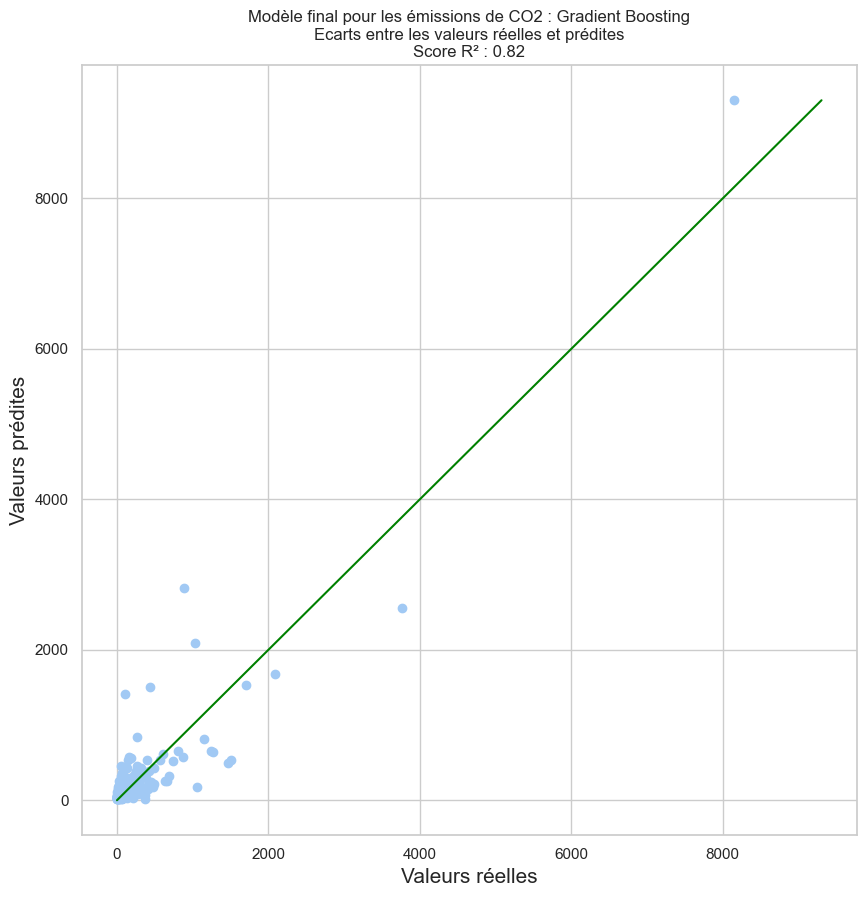

In [27]:
X = data.drop(columns={'TotalGHGEmissions', 'ENERGYSTARScore'})
y = data['TotalGHGEmissions']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)

modele_final = make_pipeline(preprocesseur, GradientBoostingRegressor(learning_rate = 0.2,
                                                                      n_estimators = 50,
                                                                      random_state=39))

modele_final.fit(X_train,y_train)
y_pred = modele_final.predict(X_test)

sns.set_theme(style='whitegrid', palette='pastel')

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred)
diag1 = max(max(y_pred), max(y_test))
diag2 = min(min(y_pred), min(y_test))
plt.plot([diag1, diag2], [diag1, diag2], c='green')
plt.xlabel('Valeurs réelles', fontsize=15)
plt.ylabel('Valeurs prédites', fontsize=15)
plt.title("Modèle final pour les émissions de CO2 : Gradient Boosting\nEcarts entre les valeurs réelles et prédites\nScore R² : "+str(round(metrics.r2_score(y_test, y_pred),2)))
plt.show()

En zoomant :

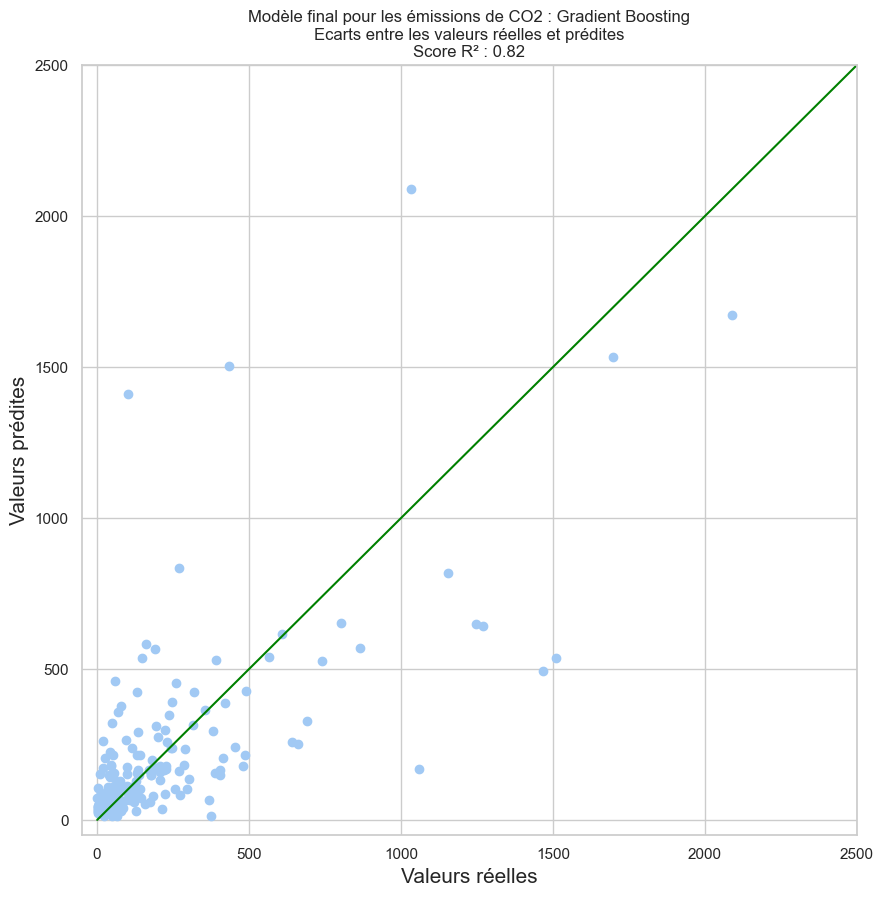

In [28]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred)
diag1 = max(max(y_pred), max(y_test))
diag2 = min(min(y_pred), min(y_test))
plt.plot([diag1, diag2], [diag1, diag2], c='green')
plt.xlabel('Valeurs réelles', fontsize=15)
plt.ylabel('Valeurs prédites', fontsize=15)
plt.title("Modèle final pour les émissions de CO2 : Gradient Boosting\nEcarts entre les valeurs réelles et prédites\nScore R² : "+str(round(metrics.r2_score(y_test, y_pred),2)))
plt.xlim(-50, 2500)
plt.ylim(-50, 2500)
plt.show()